# Goal

Checking that diffusion estimation is working properly.

* Settings to test:
  * Trying differing fragment lengths

# Setting variables

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/Ecoli/'
genomeDir = '/home/nick/notebook/SIPSim/dev/Ecoli/genomes/'

# Init

In [2]:
import glob
import nestly
from IPython.display import Image, display
import matplotlib.pyplot as plt

In [3]:
%load_ext rpy2.ipython
%matplotlib inline

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


# Setting up nestly

In [60]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('fld', 
         ['uniform,1000,2000',
          'uniform,20000,20500',
          'uniform,50000,51000',
          'normal,9000,2500',
          'normal,12000,500',
          'skewed-normal,9000,2500,-5'])

## set params
nest.add('np', [4], create_dir=False)

## input/output files
nest.add('fileName', ['ampFrags'], create_dir=False)
nest.add('genome_index', [os.path.join(genomeDir, 'genome_index.txt')], create_dir=False)
nest.add('genome_dir', [genomeDir], create_dir=False)
nest.add('primers', [os.path.join(workDir, '../', '515F-806R.fna')], create_dir=False)

# building directory tree
buildDir = os.path.join(workDir, 'diffusion')
nest.build(buildDir)

In [61]:
bashFile = os.path.join(workDir, 'SIPSimRun.sh')

In [62]:
%%writefile $bashFile
#!/bin/bash

# simulating fragments
SIPSim fragments \
    {genome_index} \
    --fp {genome_dir} \
    --fr {primers} \
    --fld {fld} \
    --flr None,None \
    --nf 10000 \
    --np {np} \
    --tbl \
    2> {fileName}.log \
    > {fileName}.txt
    
# converting to kde object
SIPSim fragment_kde \
    {fileName}.txt \
    > {fileName}_kde.pkl    
    
## plotting  
SIPSim KDE_plot \
    {fileName}_kde.pkl  \
    --xMin 1.66 --xMax 1.8 \
    -o {fileName}_kde.png  
SIPSim KDE_plot \
    {fileName}_kde.pkl  \
    --xMin 1.66 --xMax 1.8 --logY 10 \
    -o {fileName}_kde_log10.png      
    
# adding diffusion
SIPSim diffusion \
    {fileName}_kde.pkl \
    --np {np} \
    > {fileName}_kde_dif.pkl

## plotting  
SIPSim KDE_plot \
    {fileName}_kde_dif.pkl  \
    --xMin 1.66 --xMax 1.8 \
    -o {fileName}_kde_dif.png  
SIPSim KDE_plot \
    {fileName}_kde_dif.pkl  \
    --xMin 1.66 --xMax 1.8 --logY 10 \
    -o {fileName}_kde_dif_log10.png   

Overwriting /home/nick/notebook/SIPSim/dev/Ecoli/SIPSimRun.sh


In [63]:
!chmod 775 $bashFile

In [64]:
!cd $workDir; \
    nestrun -j 1 --template-file $bashFile -d diffusion

2015-07-13 14:51:38,467 * INFO * Template: ./SIPSimRun.sh
2015-07-13 14:51:38,469 * INFO * [112653] Started ./SIPSimRun.sh in diffusion/normal,12000,500
2015-07-13 14:52:08,103 * INFO * [112653] diffusion/normal,12000,500 Finished with 0
2015-07-13 14:52:08,106 * INFO * [112782] Started ./SIPSimRun.sh in diffusion/uniform,50000,51000
2015-07-13 14:53:27,363 * INFO * [112782] diffusion/uniform,50000,51000 Finished with 0
2015-07-13 14:53:27,366 * INFO * [112914] Started ./SIPSimRun.sh in diffusion/normal,9000,2500
2015-07-13 14:54:06,740 * INFO * [112914] diffusion/normal,9000,2500 Finished with 0
2015-07-13 14:54:06,744 * INFO * [113044] Started ./SIPSimRun.sh in diffusion/uniform,20000,20500
2015-07-13 14:54:43,360 * INFO * [113044] diffusion/uniform,20000,20500 Finished with 0
2015-07-13 14:54:43,364 * INFO * [113173] Started ./SIPSimRun.sh in diffusion/skewed-normal,9000,2500,-5
2015-07-13 14:55:09,334 * INFO * [113173] diffusion/skewed-normal,9000,2500,-5 Finished with 0
2015-07-13

In [65]:
!cd $workDir; \
    nestagg delim -t -k fld -d diffusion -o diffusion/ampFrags.txt ampFrags.txt

# Plotting fragments

In [66]:
%%R -i workDir
setwd(workDir)

tbl = read.delim('diffusion/ampFrags.txt', sep='\t')
tbl %>% head

    taxon_name
1 Ecoli_O157H7
2 Ecoli_O157H7
3 Ecoli_O157H7
4 Ecoli_O157H7
5 Ecoli_O157H7
6 Ecoli_O157H7
                                                                                                    scaffoldID
1 AE005174|Escherichia coli O157:H7 EDL933, complete genome. Escherichia coli O157:H7 EDL933, complete genome.
2 AE005174|Escherichia coli O157:H7 EDL933, complete genome. Escherichia coli O157:H7 EDL933, complete genome.
3 AE005174|Escherichia coli O157:H7 EDL933, complete genome. Escherichia coli O157:H7 EDL933, complete genome.
4 AE005174|Escherichia coli O157:H7 EDL933, complete genome. Escherichia coli O157:H7 EDL933, complete genome.
5 AE005174|Escherichia coli O157:H7 EDL933, complete genome. Escherichia coli O157:H7 EDL933, complete genome.
6 AE005174|Escherichia coli O157:H7 EDL933, complete genome. Escherichia coli O157:H7 EDL933, complete genome.
  fragStart fragLength   fragGC              fld
1   2102794      11712 49.45759 normal,12000,500
2     42141      116

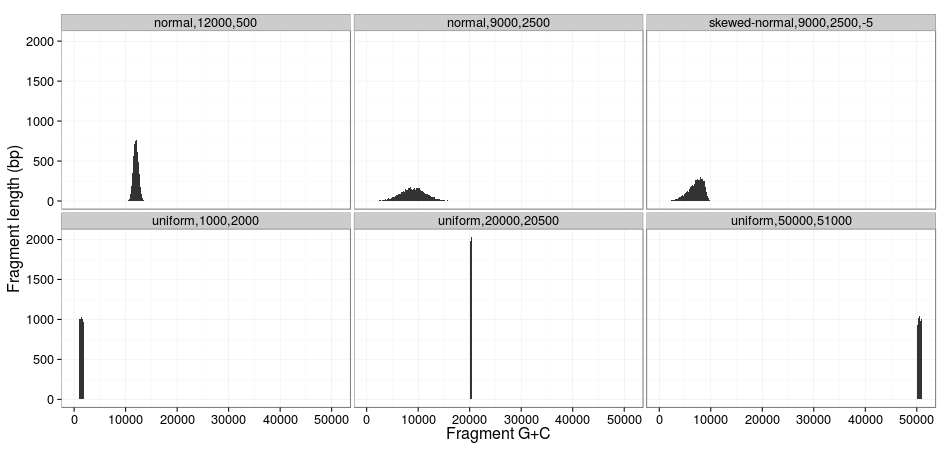

In [67]:
%%R -w 950 -h 450

ggplot(tbl, aes(fragLength)) +
    geom_histogram(binwidth=100) +
    labs(x='Fragment G+C', y='Fragment length (bp)') +
    facet_wrap(~ fld) +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.title.y=element_text(vjust=1)
        )

# Plotting diffusion KDE

## Linear scaling

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/normal,12000,500/ampFrags_kde.png


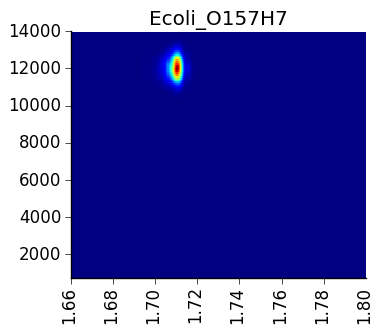

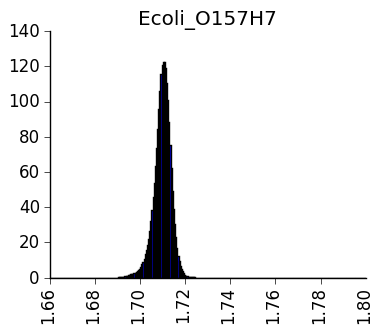

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/normal,9000,2500/ampFrags_kde.png


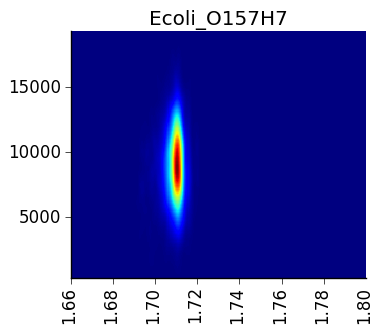

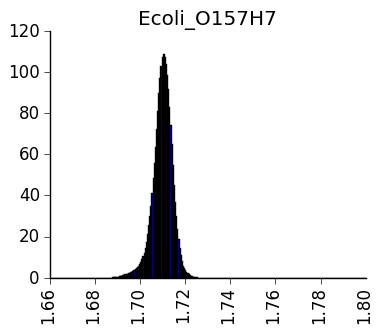

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/skewed-normal,9000,2500,-5/ampFrags_kde.png


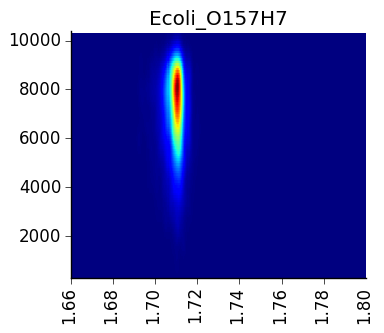

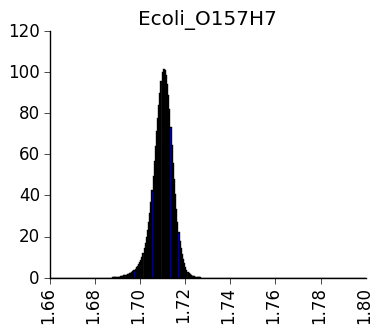

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/uniform,1000,2000/ampFrags_kde.png


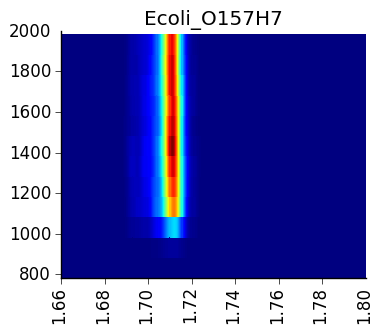

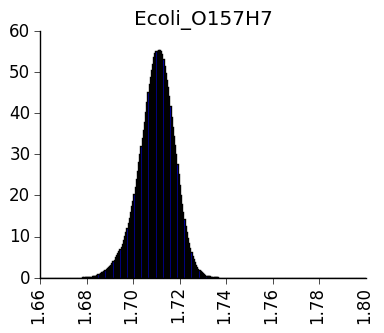

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/uniform,20000,20500/ampFrags_kde.png


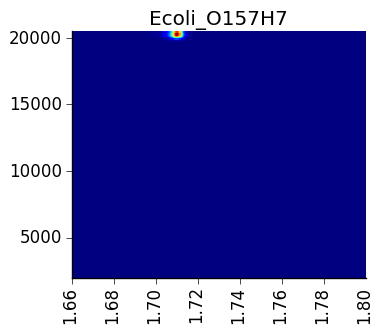

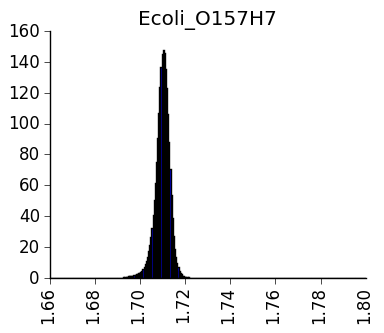

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/uniform,50000,51000/ampFrags_kde.png


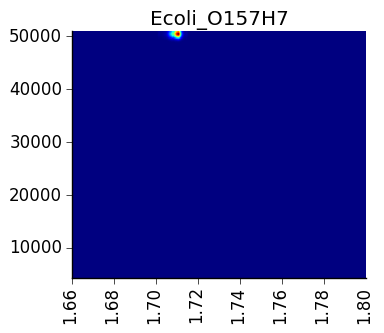

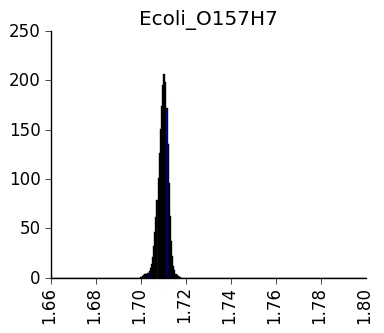

In [73]:
tmpDir = os.path.join(workDir, 'diffusion')
incorp_L1 = glob.glob(os.path.join(tmpDir, '*/ampFrags_kde.png'))
incorp_L2 = glob.glob(os.path.join(tmpDir, '*/ampFrags_kde_dif.png'))

for L1,L2 in zip(sorted(incorp_L1), sorted(incorp_L2)):
    print L1
    img1 = Image(L1, width=400, height=250)
    img2 = Image(L2, width=400, height=250)    
    display(img1, img2)

## Log10 scaling

### Without diffusion

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/normal,12000,500/ampFrags_kde_log10.png


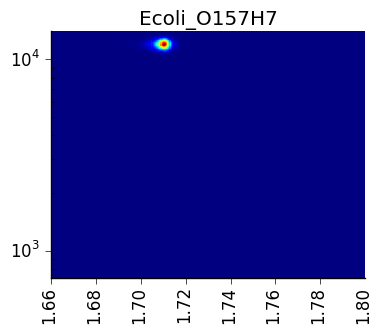

In [72]:
tmpDir = os.path.join(workDir, 'diffusion')
incorp_L1 = glob.glob(os.path.join(tmpDir, '*/ampFrags_kde_log10.png'))

for L1 in sorted(incorp_L1):
    print L1
    img1 = Image(L1, width=400, height=250)    
    display(img1)
    break

### With diffusion

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/normal,12000,500/ampFrags_kde_dif_log10.png


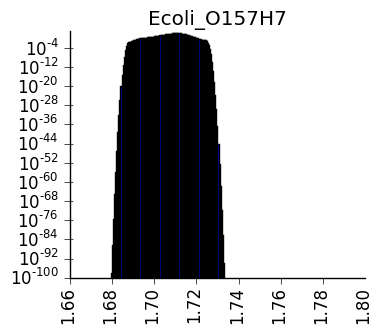

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/normal,9000,2500/ampFrags_kde_dif_log10.png


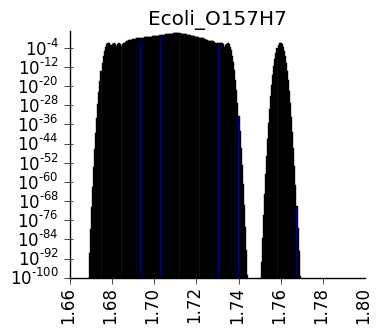

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/skewed-normal,9000,2500,-5/ampFrags_kde_dif_log10.png


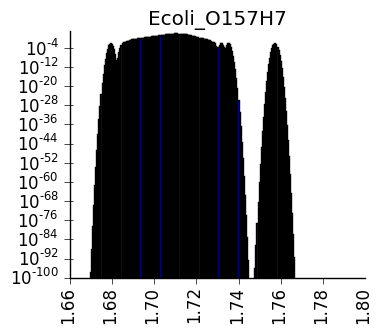

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/uniform,1000,2000/ampFrags_kde_dif_log10.png


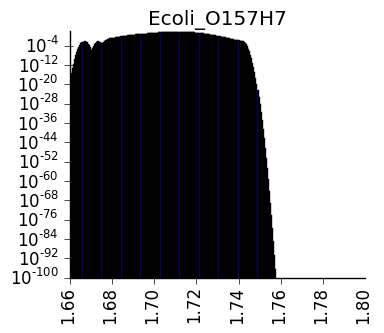

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/uniform,20000,20500/ampFrags_kde_dif_log10.png


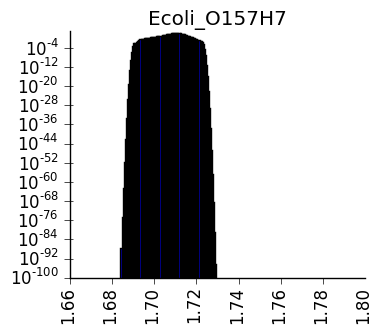

/home/nick/notebook/SIPSim/dev/Ecoli/diffusion/uniform,50000,51000/ampFrags_kde_dif_log10.png


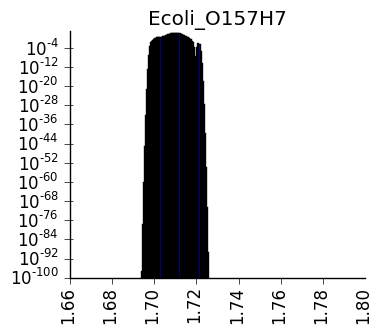

In [71]:
tmpDir = os.path.join(workDir, 'diffusion')
incorp_L1 = glob.glob(os.path.join(tmpDir, '*/ampFrags_kde_dif_log10.png'))

for L1 in sorted(incorp_L1):
    print L1
    img1 = Image(L1, width=400, height=250)    
    display(img1)